# Modelo: Red Neuronal

El modelo a entrenar en el siguiente notebook se tratará de una red neuronal. Por el tipo de modelo del que se trata, iremos mostrando la serie de pasos y decisiones hasta llegar a los hiperparámetros y estructura de la red final, en lugar de realizar dicha busqueda con GridSearch o técnicas similares

##  Librerias y funciones necesarias

Para comenzar importamos las librerias que utilizaremos. En este caso para la construcción de la red utilizaremos la libreria Keras y para evaluar las metricas utilizaremos Sklearn. Luego importamos las funciones necesarias para los preprocesamientos

In [1]:
from numpy.random import seed
seed(0)
import tensorflow.random
tensorflow.random.set_seed(0)


In [2]:
import pandas
import matplotlib.pyplot as plt
import keras
#import tensorflow as tf
#import numpy as np
import tensorflow.keras.optimizers
import tensorflow.keras.metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense #, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, roc_auc_score
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves_red
from preprocessing import graficar_matriz_confusion

Using TensorFlow backend.


## Primer preprocesamiento

En primer lugar obtenemos el dataset para entrenar y el holdout. En segundo lugar, aplicamos una función que trabaja sobre las features, generalizando algunas y dejando de lado otras según lo observado en la primer parte de este trabajo práctico. También separamos a la variable target del resto del dataset. Por último, convertimos a númericas las variables categoricas para poder entrenar nuestro modelo

In [3]:
df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df = conversion_numerica(X_df) 

Luego vamos a realizar un split del dataset para dividir en train y test. Como observamos en la primer parte de este trabajo práctico, la variable target no esta distribuida uniformente por lo cual realizamos una división estratificada

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=30,stratify=y_df)

### Primer diseño de la red

Comenzaremos con una red simple de una capa de 4 neuronas con función de activación Tanh y una ultima capa de una neurona con función de activación Sigmoidea. Esta última capa se repetirá en todas nuestras redes a construir. También se repetirá nuestra función de perdida (binary_crossentropy) y las métricas para evaluar que serán AUC y accuracy. Comenzaremos con SGD como primer optimizador

In [5]:
model = Sequential()
model.add(Dense(4,input_shape = (40,),activation='tanh'))
model.add(Dense(1, activation="sigmoid"))

Compilamos nuestro primer modelo y observamos un resumen de su composición

In [6]:
auc_ = tensorflow.keras.metrics.AUC(num_thresholds=1000)
model.compile(loss='binary_crossentropy', optimizer='SGD',metrics=[auc_,'accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 164       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


Ahora si, realicemos nuestro primer entrenamiento. Primeramente entrenaremos 100 epochs

In [7]:
history = model.fit(X_train.values, y_train,epochs=100,verbose=1,validation_data=(X_test.values, y_test))

Epoch 1/100
814/814 [==============================] - 2s 2ms/step - loss: 0.5590 - auc: 0.5941 - accuracy: 0.7493 - val_loss: 0.5148 - val_auc: 0.6541 - val_accuracy: 0.7778
Epoch 2/100
814/814 [==============================] - 1s 1ms/step - loss: 0.5077 - auc: 0.6507 - accuracy: 0.7823 - val_loss: 0.5110 - val_auc: 0.6520 - val_accuracy: 0.7778
Epoch 3/100
814/814 [==============================] - 1s 1ms/step - loss: 0.4987 - auc: 0.6903 - accuracy: 0.7817 - val_loss: 0.4892 - val_auc: 0.7258 - val_accuracy: 0.7778
Epoch 4/100
814/814 [==============================] - 1s 1ms/step - loss: 0.4874 - auc: 0.7109 - accuracy: 0.7836 - val_loss: 0.4821 - val_auc: 0.7277 - val_accuracy: 0.7778
Epoch 5/100
814/814 [==============================] - 1s 1ms/step - loss: 0.4896 - auc: 0.7167 - accuracy: 0.7774 - val_loss: 0.4902 - val_auc: 0.7397 - val_accuracy: 0.7778
Epoch 6/100
814/814 [==============================] - 1s 1ms/step - loss: 0.4741 - auc: 0.7312 - accuracy: 0.7846 - val_loss

Para evaluar los resultados obtenidos, observaremos la curva de aprendizaje tanto de la accuracy como del AUC

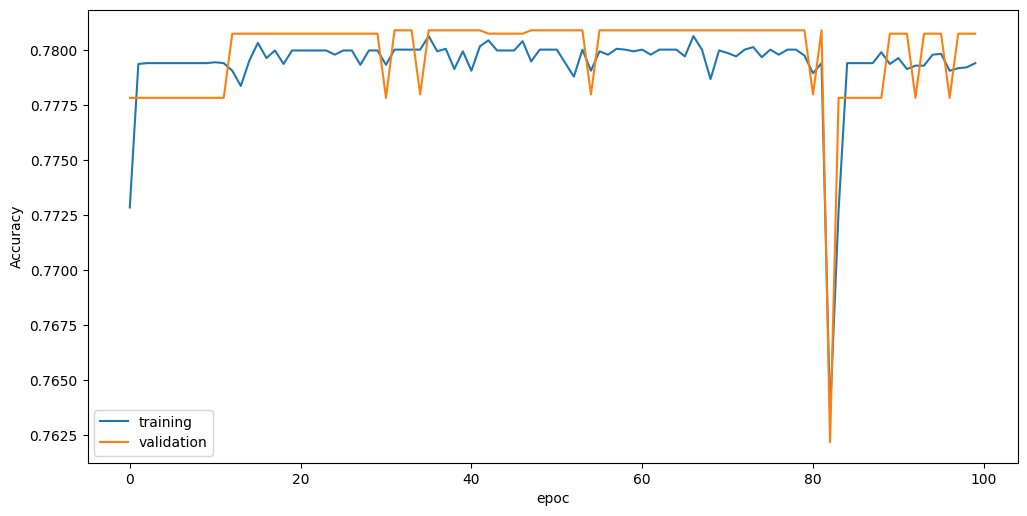

In [8]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.show()

In [9]:
history.history.keys()

dict_keys(['loss', 'auc', 'accuracy', 'val_loss', 'val_auc', 'val_accuracy'])

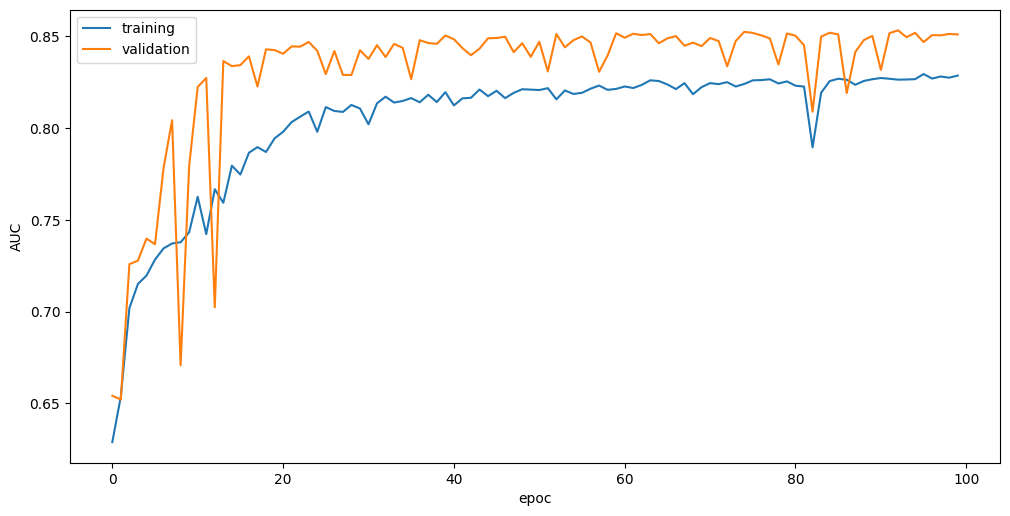

In [10]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("AUC")
plt.xlabel("epoc")
plt.plot(history.history["auc"], label="training")
plt.plot(history.history["val_auc"], label="validation")
plt.legend()
plt.show()

In [11]:
y_pred = model.predict(X_test).round()

AUC-ROC score sobre test:  0.8535609175419410
AUC-ROC score sobre train:  0.8524914212033472
Accuracy sobre test:  0.7807461999078765
              precision    recall  f1-score   support

  Bajo valor       0.93      0.81      0.87      5709
  Alto valor       0.30      0.59      0.40       804

    accuracy                           0.78      6513
   macro avg       0.62      0.70      0.63      6513
weighted avg       0.85      0.78      0.81      6513



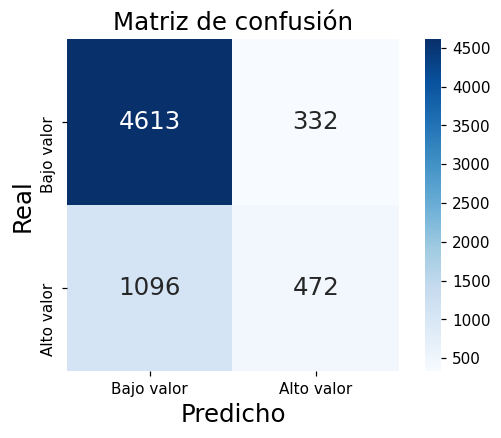

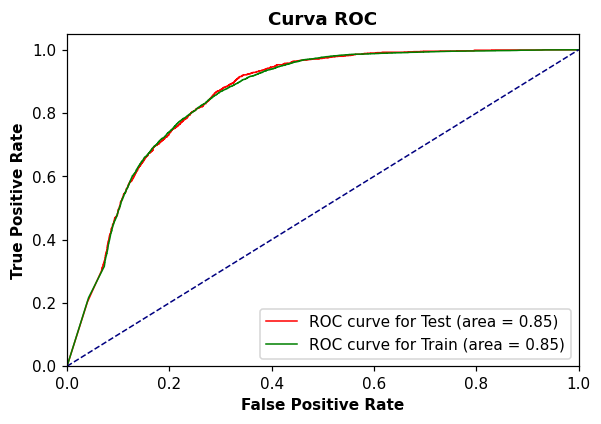

In [14]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, model.predict(X_test)))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, model.predict(X_train)))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves_red(model, X_test, y_test, X_train, y_train)

AUC-ROC score sobre test:  0.8535609175419410

AUC-ROC score sobre train:  0.8524914212033472

#### Valores de arriba a comparar

# En primer lugar diseño la red

In [13]:
ASD

NameError: name 'ASD' is not defined

In [ ]:
num_classes = 2

model = Sequential()
model.add(Dense(8,input_shape = (40,),activation='tanh'))
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

# Ya tengo el primer modelo compilado voy a entrenarlo

In [ ]:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [ ]:
history = model.fit(X_train.values, y_train,epochs=3,verbose=0,validation_data=(X_test.values, y_test))

# Grafico evolución en función de epocs

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

# Busco bajar el learning rate porque esta over shootiando, poner mas epocs y regularizo también

In [ ]:
from keras.regularizers import l2

In [ ]:
num_clases = 2
model = Sequential()
model.add(Dense(16, input_shape=(40,), activation='relu', kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.25))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.25))
model.add(Dense(4, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(num_clases, activation="softmax"))





In [ ]:
#opt = RMSprop(lr=0.0001)
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy',"AUC"])
model.summary()

In [ ]:
history = model.fit(X_train.values, y_train,verbose = 1,epochs = 100,validation_data=(X_test.values, y_test))

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("AUC")
plt.xlabel("epoc")
plt.plot(history.history["auc"], label="training")
plt.plot(history.history["val_auc"], label="validation")
plt.legend()

In [ ]:
y_test =  y_test[:,1]


In [ ]:
y_train = y_train[:,1]

In [ ]:
#y_pred = model.predict(X_test)[:,1]

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_pred

In [ ]:
y_test

In [ ]:
y_train

In [ ]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, model.predict(X_test)[:,1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, model.predict(X_train)[:,1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(model, X_test, y_test, X_train, y_train)

In [ ]:
prediccion = model.predict(X_train)

In [ ]:
prediccion[:20]

# Conclusion parcial

Como dato: probe varios optimizadores y varios learning rates y varias configuraciones de redes. El optimizador es este o el adam. El learning rate mas chicho no sirve y mas grande overshootea mucho. La red si la complejizas mas se va todo a la mierda rapidamente